# Aplicación Práctica: Predicción de Ingresos con Regresión Lasso

<a href="https://colab.research.google.com/github/josuecaldas/predict_income/blob/main/PYTHON_predict_income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objetivo:** Este cuaderno demuestra el uso de la Regresión Lasso para predecir el ingreso monetario y, fundamentalmente, para seleccionar las variables más relevantes de un conjunto de datos de alta dimensionalidad.

**Contexto de Investigación:** Utilizamos datos de la Encuesta Nacional de Hogares (ENAHO) 2020 para Lima Metropolitana. Nos enfrentamos a un problema común en las ciencias sociales: disponemos de una gran cantidad de predictores (144 en este caso) y sospechamos que solo un subconjunto de ellos es verdaderamente influyente.

**Metodología:** La Regresión Lasso es ideal para este escenario, ya que su capacidad de penalización puede reducir los coeficientes de las variables menos importantes a exactamente cero, realizando así una selección de variables automática.

### 1. Configuración del Entorno

En esta sección, importamos todas las librerías necesarias para el análisis. Utilizamos `pandas` para la manipulación de datos, `numpy` para operaciones numéricas y `scikit-learn` para el modelado y la evaluación.

In [23]:
#pip install pandas numpy seaborn matplotlib scikit-learn

In [1]:
# Librerías para manipulación y análisis de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import seaborn as sns
import matplotlib.pyplot as plt

# Clases y funciones de Scikit-Learn para el modelado
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score

# Configuración para mejorar la visualización
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

### 2. Carga y Exploración Inicial de los Datos (EDA)

Cargamos el conjunto de datos y realizamos una exploración inicial para entender su estructura y la variable que deseamos predecir.

In [6]:
# Carga de la base de datos desde el archivo CSV
data = pd.read_csv("predict_income_2020_2.csv", encoding = "latin-1")

# Eliminamos la columna 'Unnamed: 0' que parece ser un índice residual del archivo
if 'Unnamed: 0' in data.columns:
    data = data.drop('Unnamed: 0', axis=1)

# Mostramos las primeras filas para verificar la carga
data.head()

,num__p208a_20,num__p104_20,num__p301b_20,cat__p207_20_2,cat__p110a1_20_2,cat__p1121_20_1,cat__p1124_20_1,cat__p1125_20_1,cat__p1126_20_1,cat__p1127_20_1,...,cat__p401f_20_2_1,cat__p558c_20_2_1,cat__p558c_20_3_1,cat__p558c_20_4_1,cat__p558c_20_5_1,cat__p558c_20_6_1,cat__p558c_20_7_1,cat__p558c_20_8_1,cat__p558c_20_9_1,log_ingmo2hd
0,0.892167,-0.589575,0.769687,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.985195
1,-1.200039,-0.589575,-0.558632,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.093405
2,0.630641,-0.007426,-2.551110,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.052985
3,0.761404,-0.589575,0.769687,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.699472
4,1.022930,-0.007426,-1.222791,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.478868


In [8]:
# --- Código para generar el perfil del dataset ---

# Asegúrate de que 'data' esté cargado como en tu script original
# data = pd.read_csv("predict_income_2020.csv", encoding = "latin-1")
# if 'Unnamed: 0' in data.columns:
#     data = data.drop('Unnamed: 0', axis=1)

# Crear una lista para almacenar la información de cada columna
profile_data = []

# Iterar sobre cada columna en el DataFrame
for col in data.columns:
    # Tipo de dato de la columna
    dtype = data[col].dtype
    
    # Número de valores faltantes
    missing_values = data[col].isnull().sum()
    
    # Porcentaje de valores faltantes
    missing_percentage = (missing_values / len(data)) * 100
    
    # Número de valores únicos
    unique_values_count = data[col].nunique()
    
    # Obtener algunos ejemplos de valores únicos (máximo 10 para no saturar)
    unique_examples = data[col].unique()
    if len(unique_examples) > 10:
        unique_examples_str = str(list(unique_examples[:5])) + '...'
    else:
        unique_examples_str = str(list(unique_examples))

    # Guardar la información en la lista
    profile_data.append({
        'Variable': col,
        'Tipo de Dato': dtype,
        '% Faltante': round(missing_percentage, 2),
        'Valores Únicos': unique_values_count,
        'Ejemplos Únicos': unique_examples_str
    })

# Crear un DataFrame con el perfil
data_profile = pd.DataFrame(profile_data)

# Configurar pandas para mostrar todas las filas
pd.set_option('display.max_rows', None)

# Mostrar el perfil completo
print("--- Perfil del Dataset ---")
display(data_profile)

# Restaurar la opción de visualización por defecto si lo deseas
pd.reset_option('display.max_rows')

--- Perfil del Dataset ---


,Variable,Tipo de Dato,% Faltante,Valores Únicos,Ejemplos Únicos
0,num__p208a_20,float64,0.0,74,"[np.float64(0.8921670227484464), np.float64(-1..."
1,num__p104_20,float64,0.0,14,"[np.float64(-0.5895746359286274), np.float64(-..."
2,num__p301b_20,float64,0.0,8,"[np.float64(0.7696871158930635), np.float64(-0..."
3,cat__p207_20_2,float64,0.0,2,"[np.float64(1.0), np.float64(0.0)]"
4,cat__p110a1_20_2,float64,0.0,2,"[np.float64(0.0), np.float64(1.0)]"
5,cat__p1121_20_1,float64,0.0,2,"[np.float64(1.0), np.float64(0.0)]"
6,cat__p1124_20_1,float64,0.0,2,"[np.float64(0.0), np.float64(1.0)]"
7,cat__p1125_20_1,float64,0.0,2,"[np.float64(0.0), np.float64(1.0)]"
8,cat__p1126_20_1,float64,0.0,2,"[np.float64(0.0), np.float64(1.0)]"
9,cat__p1127_20_1,float64,0.0,2,"[np.float64(0.0), np.float64(1.0)]"


#### Diccionario de Variables (Ejemplos)

Para que el análisis sea interpretable, es fundamental entender qué significan las variables. Los nombres como `p207_20` provienen de la encuesta y son poco intuitivos. A continuación, se describen algunas variables clave y la variable objetivo:

| Código de Variable | Descripción Corta |
| :--- | :--- |
| **`ingmo2hd`** | **Ingreso monetario neto anual (Variable Objetivo)** |
| `p207_20` | Sexo |
| `p208a_20` | Edad en años cumplidos |
| `p301b_20` | Último año o grado de estudios aprobado |
| `p501_20` | Tuvo algún trabajo la semana pasada |
| `p1142_20` | El hogar tiene teléfono celular |
| `p1144_20` | El hogar tiene conexión a internet |

Estadísticas Descriptivas del Ingreso (ingmo2hd):
count    6193.000000
mean        9.187397
std         1.445281
min         2.564949
25%         8.519989
50%         9.457591
75%        10.118921
max        12.854834
Name: log_ingmo2hd, dtype: float64


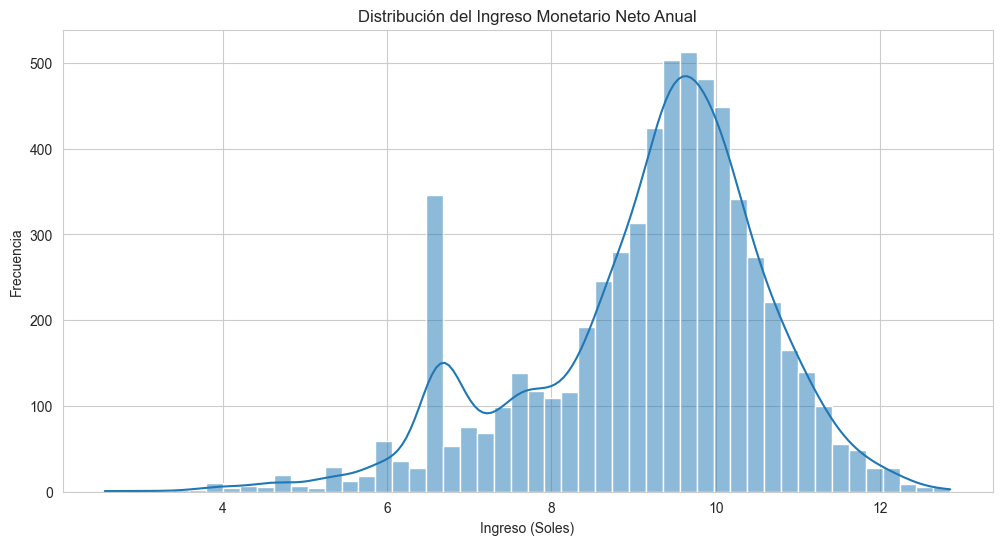

In [7]:


# Analizar la distribución de la variable objetivo (ingreso)
print("Estadísticas Descriptivas del Ingreso (ingmo2hd):")
print(data['log_ingmo2hd'].describe())

# Visualizar la distribución del ingreso
plt.figure(figsize=(12, 6))
sns.histplot(data['log_ingmo2hd'], kde=True, bins=50)
plt.title('Distribución del Ingreso Monetario Neto Anual')
plt.xlabel('Ingreso (Soles)')
plt.ylabel('Frecuencia')
plt.show()

### 3. Preparación para el Modelado

Aquí, separamos nuestros datos en:
1.  **Variable Predicha (y):** `ingmo2hd`.
2.  **Variables Predictoras (X):** Todas las demás variables.

Posteriormente, dividimos los datos en conjuntos de **entrenamiento (training)** y **prueba (test)**. Este es un paso crucial para evaluar el modelo de forma objetiva, probando su rendimiento en datos que no utilizó para aprender.

In [27]:
# 1. Separación de la variable predicha y los predictores
y = data['ingmo2hd']
X = data.drop('ingmo2hd', axis=1)

# 2. División en conjuntos de entrenamiento (70%) y prueba (30%)
# Usamos random_state para que la división sea reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state=42)

print(f"Dimensiones del conjunto de entrenamiento (X_train): {X_train.shape}")
print(f"Dimensiones del conjunto de prueba (X_test): {X_test.shape}")

Dimensiones del conjunto de entrenamiento (X_train): (5558, 143)
Dimensiones del conjunto de prueba (X_test): (2383, 143)


### 4. Implementación y Entrenamiento del Modelo Lasso

Ahora procedemos a entrenar nuestro modelo. Utilizamos `LassoCV`, que no solo ajusta un modelo Lasso, sino que también utiliza **validación cruzada (Cross-Validation)** para encontrar el mejor hiperparámetro de penalización (`alpha`). Esto nos libera de tener que elegir un `alpha` manualmente y resulta en un modelo más robusto.

In [28]:
# Definimos el modelo Lasso con Validación Cruzada
# Se probarán 200 valores de alpha en un rango logarítmico
lasso_cv_model = LassoCV(alphas=np.logspace(-4, 4, 200), cv=5, random_state=42)

# Entrenamos el modelo con los datos de entrenamiento
print("Entrenando el modelo LassoCV... (puede tardar unos momentos)")
lasso_cv_model.fit(X_train, y_train)
print("Entrenamiento completado.")

# Mostramos el mejor alpha encontrado por la validación cruzada
print(f"\nMejor alpha encontrado: {lasso_cv_model.alpha_:.4f}")

Entrenando el modelo LassoCV... (puede tardar unos momentos)
Entrenamiento completado.

Mejor alpha encontrado: 26.7384


### 5. Evaluación e Interpretación de Resultados

Con el modelo ya entrenado, evaluamos su desempeño en el **conjunto de prueba**, que contiene datos que el modelo nunca antes ha visto. Esto nos da una medida honesta de su capacidad de generalización.

In [29]:
# Realizar predicciones sobre el conjunto de prueba
y_pred_lasso = lasso_cv_model.predict(X_test)

# Calcular métricas de error
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Raíz del Error Cuadrático Medio (RMSE) en el conjunto de prueba: {rmse_lasso:.2f}")
print(f"Coeficiente de Determinación (R²) en el conjunto de prueba: {r2_lasso:.4f}")

Raíz del Error Cuadrático Medio (RMSE) en el conjunto de prueba: 22764.85
Coeficiente de Determinación (R²) en el conjunto de prueba: 0.3831


#### Análisis de Coeficientes: El Poder de la Selección de Variables

El resultado más importante de Lasso para las ciencias sociales es la **interpretación de los coeficientes**. Para facilitar esto, primero crearemos un diccionario que traduce los códigos de las variables a etiquetas comprensibles.

In [30]:
# Creación del diccionario para mapear códigos a etiquetas legibles
# (Este es un subconjunto, se pueden añadir más según sea necesario)
variable_labels = {
    'p207_20': 'Sexo',
    'p208a_20': 'Edad',
    'p104_20': 'Nro. Habitaciones Vivienda',
    'p110a1_20': 'Agua es Potable',
    'p1121_20': 'Alumbrado: Electricidad',
    'p1142_20': 'Hogar con Celular',
    'p1143_20': 'Hogar con TV Cable',
    'p1144_20': 'Hogar con Internet',
    'p301b_20': 'Años de Estudio Aprobados',
    'p314a_20': 'Usó Internet Último Mes',
    'p501_20': 'Trabajó la Última Semana',
    'p558a1_20': 'Afiliado a AFP',
    'p558a2_20': 'Afiliado a ONP',
    'p558e1_1_20': 'Tiene Cuenta de Ahorros',
    'p401_20': 'Padece Enfermedad Crónica'
}

# Crear un DataFrame con los predictores y sus coeficientes
coeficientes_lasso = pd.DataFrame({
    'predictor_code': X.columns,
    'coef': lasso_cv_model.coef_
})

# Mapear los códigos a las etiquetas legibles
coeficientes_lasso['predictor_label'] = coeficientes_lasso['predictor_code'].map(variable_labels).fillna(coeficientes_lasso['predictor_code'])

# Filtrar los coeficientes que no son cero y ordenar por su valor
coeficientes_seleccionados = coeficientes_lasso[coeficientes_lasso['coef'] != 0].sort_values(by='coef', ascending=False)

print(f"De {len(coeficientes_lasso)} predictores iniciales, Lasso seleccionó {len(coeficientes_seleccionados)}.")
print("\nPredictores más importantes seleccionados por el modelo Lasso:")

# Mostrar la tabla con etiquetas legibles
print(coeficientes_seleccionados[['predictor_label', 'coef']].round(2))

De 143 predictores iniciales, Lasso seleccionó 65.

Predictores más importantes seleccionados por el modelo Lasso:
                predictor_label      coef
131                 p301a_20_11  33577.39
41      Tiene Cuenta de Ahorros  10717.65
42                  p558e1_2_20   9356.74
130                 p301a_20_10   8699.01
39                    p558a4_20   4065.22
43                  p558e1_3_20   2399.94
71                    p101_20_2   2226.05
30                    p5564a_20   1789.89
21                  p314b1_2_20   1610.94
45                  p558e1_7_20   1595.85
20                  p314b1_1_20   1514.62
133                  p401f_20_2   1468.18
44                  p558e1_6_20   1443.76
79                    p102_20_7   1172.92
127                  p301a_20_7   1093.54
22                  p314b1_6_20    984.12
59                     p4022_20    786.79
17                      p306_20    722.40
2    Nro. Habitaciones Vivienda    695.22
82                   p105a_20_2    626.17
84 

C:\Users\zadel\AppData\Local\Temp\ipykernel_6484\3088531810.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coef', y='predictor_label', data=coeficientes_seleccionados, palette='viridis')


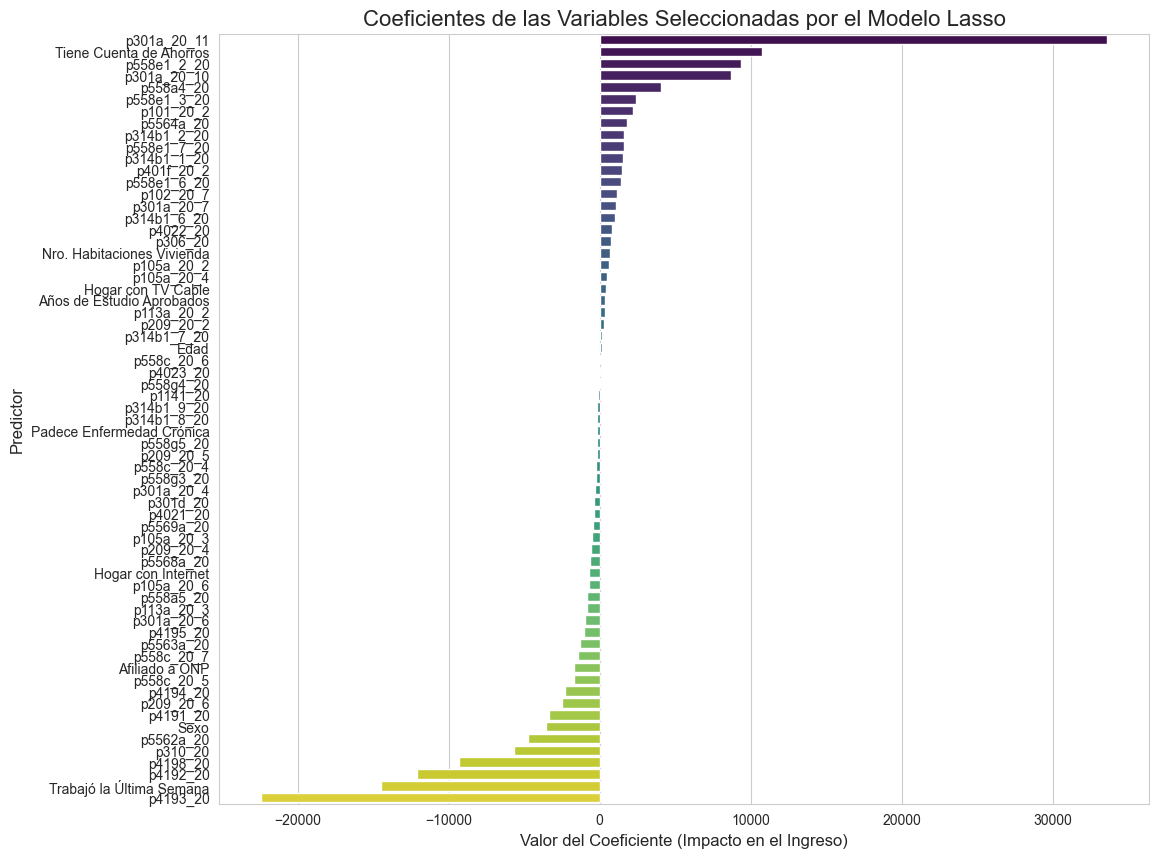

In [31]:
# Visualizar los coeficientes más importantes usando las etiquetas legibles
plt.figure(figsize=(12, 10))
sns.barplot(x='coef', y='predictor_label', data=coeficientes_seleccionados, palette='viridis')
plt.title('Coeficientes de las Variables Seleccionadas por el Modelo Lasso', fontsize=16)
plt.xlabel('Valor del Coeficiente (Impacto en el Ingreso)', fontsize=12)
plt.ylabel('Predictor', fontsize=12)
plt.show()